In [1]:
# Import libraries
from sqlalchemy import create_engine
import pymssql
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
%matplotlib inline


## 1. Loading and Exploring the Data

Let's go ahead and read in the dataset first.

In [3]:
#Read the tables
incident_data = pd.read_pickle("incident_data.pkl")
crime_class_data = pd.read_pickle("crime_class_data.pkl")
weather_data = pd.read_pickle("weather_data.pkl")
location_data = pd.read_pickle("location_data.pkl")

In [4]:
print "Number of incidents : {}, Number of columns : {}".format(incident_data.shape[0], incident_data.shape[1])
print "Number of crime classes : {}, Number of columns : {}".format(crime_class_data.shape[0], crime_class_data.shape[1])
print "Number of weather data : {}, Number of columns : {}".format(weather_data.shape[0], weather_data.shape[1])
#print "Number of census data : {}, Number of columns : {}".format(census_data.shape[0], census_data.shape[1])
print "Number of location data : {}, Number of columns : {}".format(location_data.shape[0], location_data.shape[1])

Number of incidents : 68071, Number of columns : 30
Number of crime classes : 228, Number of columns : 3
Number of weather data : 48738, Number of columns : 21
Number of location data : 24136, Number of columns : 15


In [5]:
incident_data.head()

,id,building_code,case_log_id,case_log_crime_id,case_number,date_time_occurred_from,date_time_occurred_to,date_time_reported,name,other,...,victim_sex,crime_class_id,location_id,case_status,arrest,property_stolen,stolen_property_value,recovered_status,recovered_value,synopsis
0,1,,394798,394798,140000260,2014-01-07 09:00:00,2014-01-07 09:00:00,2014-01-07 09:00:00,,,...,,101,4715,,,,,,,&lt;Narrative&gt;&amp;lt;HTML&amp;gt;&amp;lt;H...
1,2,,395205,395205,140000650,2014-01-15 02:44:00,2014-01-15 02:44:00,2014-01-15 02:44:00,,,...,,134,5337,,"A,","WINDOW,CUTTER,ROD,GLOVES,PIPE,BAG,",50.00,,0.00,&lt;Narrative&gt;&amp;lt;HTML&amp;gt;&amp;lt;H...
2,3,,395609,395609,140001030,2014-01-22 16:34:00,2014-01-22 16:34:00,2014-01-22 16:34:00,,,...,,69,2298,,,,,,,
3,4,,395938,395938,140001330,2014-01-28 15:29:00,2014-01-28 15:29:00,2014-01-28 15:29:00,,,...,,83,1099,,,"ROUNDS,AMMO,",0.00,,0.00,&lt;Narrative&gt;&amp;lt;HTML&amp;gt;&amp;lt;H...
4,5,,395941,395941,140001333,2014-01-28 16:10:00,2014-01-28 16:10:00,2014-01-28 16:10:00,,,...,,74,3359,,"N,",,,,,&lt;Narrative&gt;&amp;lt;HTML&amp;gt;&amp;lt;H...


In [6]:
crime_class_data.head()

,id,crime_class,crime_description
0,0,DEFAULT,DEFAULT
1,1,PROSTITUTE,PROSTITUTION
2,2,AO MISD,ALL OTHER MISDEMEANORS
3,3,THEFT ATT,ATTEMPT THEFT NO LOSS/DAMAGE
4,4,TEST,TEST TRANSLATION


In [7]:
location_data.head()

,id,address,street_name,building_code,city,hash_code,latitude,longitude,location_criteria,state,unit_no,zip_code,business_type_id,beat,site_code
0,0,DEFAULT,None,None,None,None,0.000000,0.00000,0,CA,None,None,1,None,None
1,1,920 S HOBART #105,None,None,LOS ANGELES,None,0.000000,0.00000,0,None,None,None,1,None,None
2,2,5000 REYNARD AV,None,None,GLENDALE,None,34.248067,-118.26394,0,None,None,None,1,None,None
3,3,1825 ARVIN DR,None,None,GLENDALE,None,34.172300,-118.22585,0,None,None,None,1,None,None
4,4,N CENTRAL AV/W DORAN ST,None,None,GLENDALE,None,34.153781,-118.25793,0,None,None,None,1,None,None


In [8]:
weather_data.head()

,id,apparent_temperature,cloud_cover,date_time_occurred,dew_point,humidity,incident_id,latitude,longitude,nearest_storm_bearing,...,ozone,precip_intensity,precip_probability,pressure,summary,temperature,visibility,wind_bearing,wind_speed,zone
0,1,29.12,0.62,None,9.07,0.30,1,30.445622,-84.314895,0.0,...,0.0,0.0,0.0,1026.66,Mostly Cloudy,37.78,10.00,313.0,14.61,America/New_York
1,2,53.48,0.00,None,43.34,0.68,2,30.445622,-84.314895,0.0,...,0.0,0.0,0.0,1015.95,Clear,53.48,10.00,320.0,4.98,America/New_York
2,3,54.39,0.00,None,24.55,0.31,3,30.445622,-84.314895,0.0,...,0.0,0.0,0.0,1012.63,Clear,54.39,10.00,314.0,12.98,America/New_York
3,4,62.41,1.00,None,56.80,0.82,4,30.445622,-84.314895,0.0,...,0.0,0.0,0.0,1014.15,Overcast,62.41,9.74,303.0,4.22,America/New_York
4,5,62.41,1.00,None,56.80,0.82,5,30.445622,-84.314895,0.0,...,0.0,0.0,0.0,1014.15,Overcast,62.41,9.74,303.0,4.22,America/New_York


## 2. Preparing the Data

In this section, we will prepare the data for modeling, training and testing.

In [9]:
def missing_threshold(dataframe,threshold):
    cols_in_threshold = []
    for col in dataframe.columns:
        if dataframe.shape[0] * threshold < dataframe[col].isnull().sum():
            cols_in_threshold.append(col)
    return cols_in_threshold   

#Join with incident table the crime_class table
Glendale_Crime_data  = pd.merge(incident_data, crime_class_data, left_on='crime_class_id', right_on="id")

#Join with the location table
Glendale_Crime_data  = pd.merge(Glendale_Crime_data, location_data, left_on='location_id', right_on="id")

#Join with location weather enricher
Glendale_Crime_data  = pd.merge(Glendale_Crime_data, weather_data, left_on='id', right_on="id")

In [10]:
print "Number of Glendale crime data including enricher data: {}, Number of columns : {}".format(Glendale_Crime_data.shape[0], Glendale_Crime_data.shape[1])

Number of Glendale crime data including enricher data: 68071, Number of columns : 68


In [11]:
Glendale_Crime_data = Glendale_Crime_data.applymap(lambda x: np.nan if isinstance(x, basestring) and not x else x)

cols_to_delete = missing_threshold(Glendale_Crime_data,.9)

Glendale_Crime_data.drop(cols_to_delete, axis = 1, inplace = True)

In [12]:
num_columns_to_delete = ["id_x",
                        "suspect_age",
                        "victim_age",
                        "crime_class_id",
                        "location_id",
                        "id_y",
                        "id",
                        "location_criteria",
                        "business_type_id",
                        'apparent_temperature', 
                        "cloud_cover",
                        'incident_id',
                        "latitude_y",
                        "longitude_y", 
                        "nearest_storm_bearing",
                        "nearest_storm_distance",
                        "ozone",
                        "precip_intensity",
                        "pressure",
                        "wind_bearing",
                        "wind_speed"]

Glendale_Crime_data.drop(num_columns_to_delete,axis = 1, inplace = True)

In [13]:
cat_columns_to_delete = ["case_log_id",
                        "case_log_crime_id",
                        "case_number",
                        'date_time_occurred_to',
                        'date_time_reported',
                        'public_information',
                        'arrest',
                        'property_stolen',
                        'stolen_property_value',
                        'recovered_value',
                        'crime_description', 
                        "address",
                        "summary",
                        "zone"]

Glendale_Crime_data.drop(cat_columns_to_delete,axis = 1, inplace = True)

### Preprocess feature columns - feature engineering

In [14]:
def preprocess_data(df):
    
    df['Year'] = df['date_time_occurred_from'].map(lambda x: x.year)
    df['Month'] = df['date_time_occurred_from'].map(lambda x: x.month)
    df['Day'] = df['date_time_occurred_from'].map(lambda x: x.day) 
    df['Hour'] = df['date_time_occurred_from'].map(lambda x: x.hour) 
    df['DayOfWeek'] = df['date_time_occurred_from'].map(lambda x: x.dayofweek) 
    df['Dark'] = df['date_time_occurred_from'].apply(lambda x: 1 if (x.hour >= 20 or x.hour < 5) else 0)
    
    #Remove all the cities that are not Glendale
    df = df[df.city == "GLENDALE"]
    #df.drop('city',axis = 1, inplace = True)   
    
    #Make sure the location is in Glendale
    df = df[(df['longitude_x'] < -118.200180) &(df['longitude_x'] > -118.299950)]
    df = df[(df['latitude_x'] < 34.257681) & (df['latitude_x'] > 34.119281)]
    
#     Fill missing stolen property data with "NA"
#     df['property_stolen'].fillna('NA', inplace=True)  
    dummy_days = pd.get_dummies(df["DayOfWeek"], prefix='DAY')
    df = df.join(dummy_days)
    
    return df
    

Glendale_City_Crime_data = preprocess_data(Glendale_Crime_data)

In [15]:
Glendale_Crime_data.head()

,date_time_occurred_from,crime_class,city,latitude_x,longitude_x,dew_point,humidity,precip_probability,temperature,visibility,Year,Month,Day,Hour,DayOfWeek,Dark
0,2014-01-07 09:00:00,PER DEAD,GLENDALE,34.179528,-118.19558,67.02,0.82,0.0,72.97,9.99,2014,1,7,9,1,0
1,2016-11-08 00:01:00,COURTESY,GLENDALE,34.179528,-118.19558,67.02,0.82,0.0,72.97,9.99,2016,11,8,0,1,1
2,2014-01-27 16:44:00,PER DEAD,GLENDALE,34.192874,-118.22582,59.55,0.92,0.0,62.03,0.90,2014,1,27,16,0,0
3,2014-04-04 05:00:00,BURGLARY,GLENDALE,34.192874,-118.22582,59.55,0.92,0.0,62.03,0.90,2014,4,4,5,4,0
4,2014-02-01 08:00:00,SUS CIRC,GLENDALE,34.192874,-118.22582,59.55,0.92,0.0,62.03,0.90,2014,2,1,8,5,0


In [16]:
cols_to_del = ['date_time_occurred_from', 
               'city']
Glendale_City_Crime_data.drop(cols_to_del, axis = 1, inplace = True)

In [17]:
cats= pd.read_csv('cats.csv')
cats.drop("Desc", axis = 1, inplace = True)
cats.set_index('ID', drop=True, inplace=True)
cats_dict = cats.to_dict(orient="index")

cats1= pd.read_csv('cats1.csv',sep=',\s+', engine='python')
cats1.drop(["Type","Desc", "All"], axis = 1, inplace = True)
cats1.Name = cats1.Name.str.replace("'","")
cats1.Relate = cats1.Relate.str.replace("'","")

In [18]:
categories = {}
for index, row in cats1.iterrows():
    group = []
    ids = row['Relate'].split(',')
    for id in ids:
        group.append(cats_dict[int(id)]["Name"])
    categories[row['Name']] = group

In [19]:
groups = {}
groups['Arson'] = categories['Arson']

groups['Robbery'] = categories['Robbery']

groups['Sex Offense'] = categories['Sex Offense'] + \
                        categories['Rape'] 
    
groups['Vandalism'] = categories['Vandalism'] + \
                      categories['Graffiti'] 
    
groups['Theft'] = categories['Theft-Grand'] + \
                  categories['Theft-Petty'] + \
                  categories['Theft-Grand Auto'] + \
                  categories['Theft-Grand Person']

#Remved Other            
groups['Burglary'] = categories['Commercial'] + \
                     categories['Burglary'] + \
                     categories['Motor Vehicle'] + \
                     categories['Fraud']
                     #categories['Other']

groups['Assault'] = categories['Assault']

#Why Homeland Security part of Violent Crimes
groups['Violent Crimes'] = categories['Abuse'] + \
                           categories['Homeland Security'] + \
                           categories['Firearms']
                 
                
groups['Manslaughter'] = categories['Murder'] + \
                         categories['Manslaughter']          
               

groups['Quality of Life & 911'] = categories['Drugs'] + \
                                  categories['Fire'] + \
                                  categories['Suicide'] + \
                                  categories['Missing'] +\
                                  categories['Alcohol']

groups['Traffic'] = categories['Traffic'] + \
                    categories['DUI']
    

groups['Violations and Fraud'] = categories['Embezzlement'] + \
                                  categories['Violations'] + \
                                  categories['Court'] + \
                                  categories['Fraud'] 
            
groups['Internet Crime'] = categories['Internet Crime'] + \
                           categories['Identity Theft']
    
groups['Warrants and Registrants'] = categories['Registrants'] + \
                                  categories['Warrant']
    
groups['Assistance and Recovery'] = categories['Assistance'] + \
                                    categories['Recovered']   
    
    
groups['Juvenile Related'] = categories['Juvenile'] 

groups['Other'] = categories['Other']

In [20]:
#Reducing the classes into 5

main_groups = {}
main_groups['Crime Against Persons'] = groups['Robbery'] + \
                                  groups['Sex Offense'] + \
                                  groups['Assault'] + \
                                  groups['Manslaughter'] + \
                                  groups['Juvenile Related'] + \
                                  groups['Violent Crimes']
                    
main_groups['Crime Against Property'] = groups['Arson'] + \
                                   groups['Vandalism'] + \
                                   groups['Theft'] + \
                                   groups['Burglary']  
            
main_groups['Traffic'] = groups['Traffic']

main_groups['Quality of Life'] = groups['Quality of Life & 911'] + \
                            groups['Violations and Fraud'] + \
                            groups['Internet Crime'] + \
                            groups['Warrants and Registrants']
            
main_groups['Other'] = groups['Assistance and Recovery'] + \
                  groups['Other'] 

In [21]:
m2 = {v: k for k,vv in main_groups.items() for v in vv}
Glendale_City_Crime_data['Main Category'] = Glendale_City_Crime_data.crime_class.map(m2).astype("category", categories=set(m2.values()))
Glendale_City_Crime_data.dropna(subset = ['Main Category'], inplace= True)

## 3. Exploratory Data Analysis

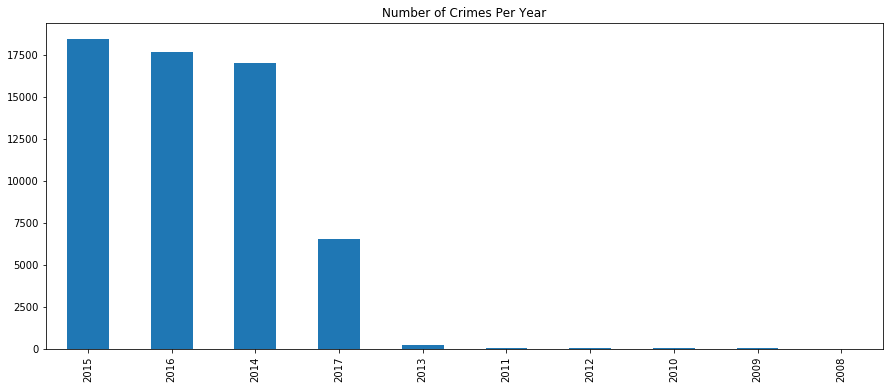

In [22]:
Glendale_City_Crime_data['Year'].value_counts().head(10).plot(figsize=(15,6),kind='bar', title = 'Number of Crimes Per Year')

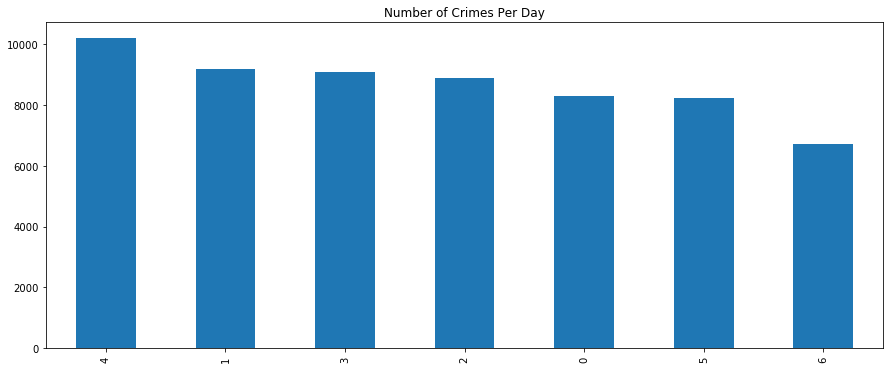

In [23]:
Glendale_City_Crime_data['DayOfWeek'].value_counts().head(10).plot(figsize=(15,6),kind='bar', title = 'Number of Crimes Per Day')

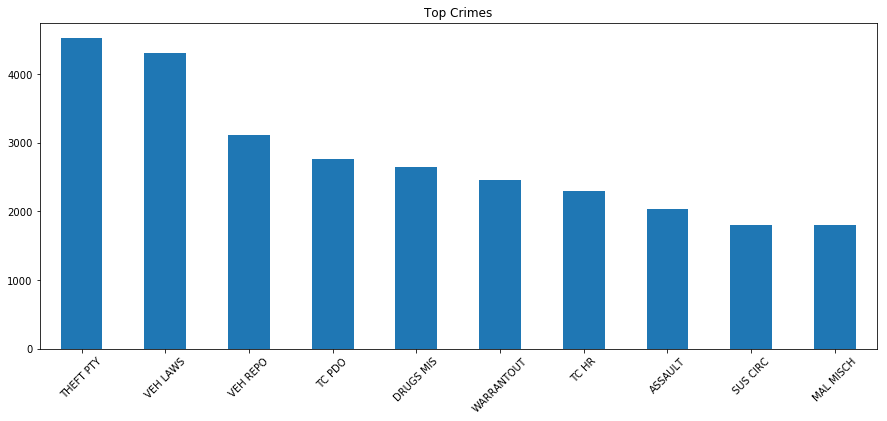

In [24]:
Glendale_City_Crime_data['crime_class'].value_counts().head(10).plot(figsize=(15,6),kind='bar', title = 'Top Crimes', rot = 45)

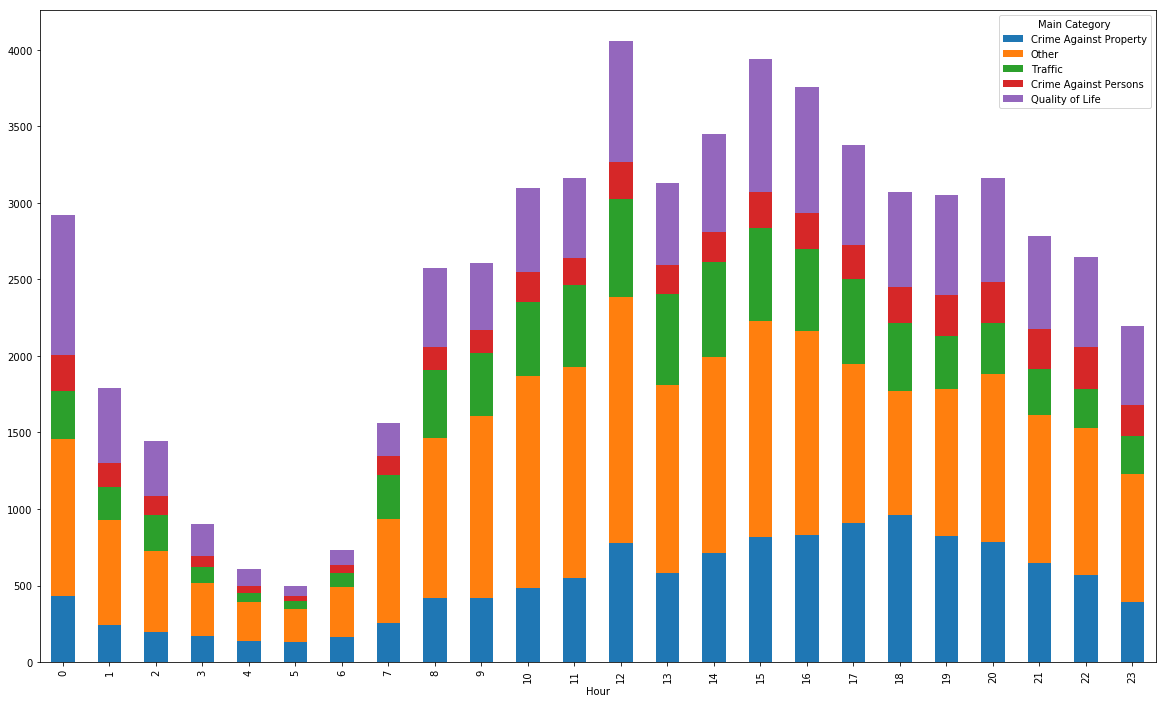

In [25]:
Glendale_City_Crime_data.groupby(['Hour','Main Category']).size().unstack().plot(kind='bar', stacked=True, 
                                                                          legend=True, figsize=(20,12))

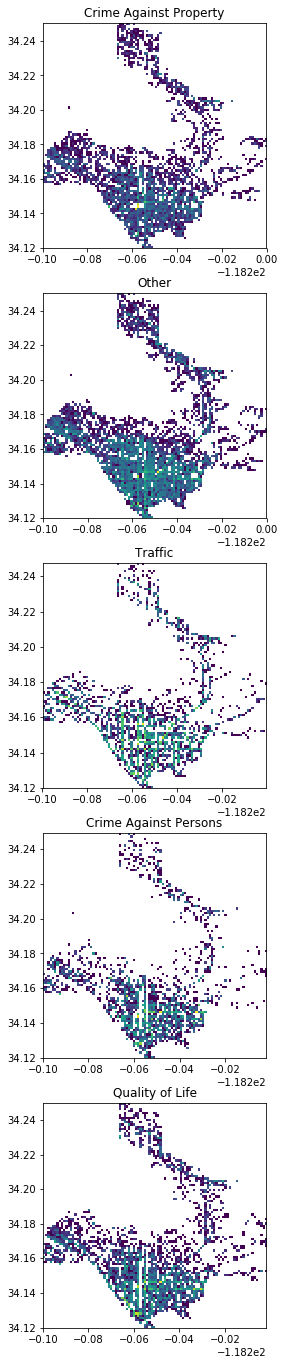

In [26]:
NX=100
NY=100
groups = Glendale_City_Crime_data.groupby('Main Category')
ii=1
plt.figure(figsize=(4,24))
for name, group in groups:
    plt.subplot(5,1,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.longitude_x),np.array(group.latitude_x), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=-118.29995,34.119281,-118.20018,34.257681&bboxSR=4326&imageSR=4326&size=1800,2496&dpi=96&format=png32&f=image


//anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
//anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


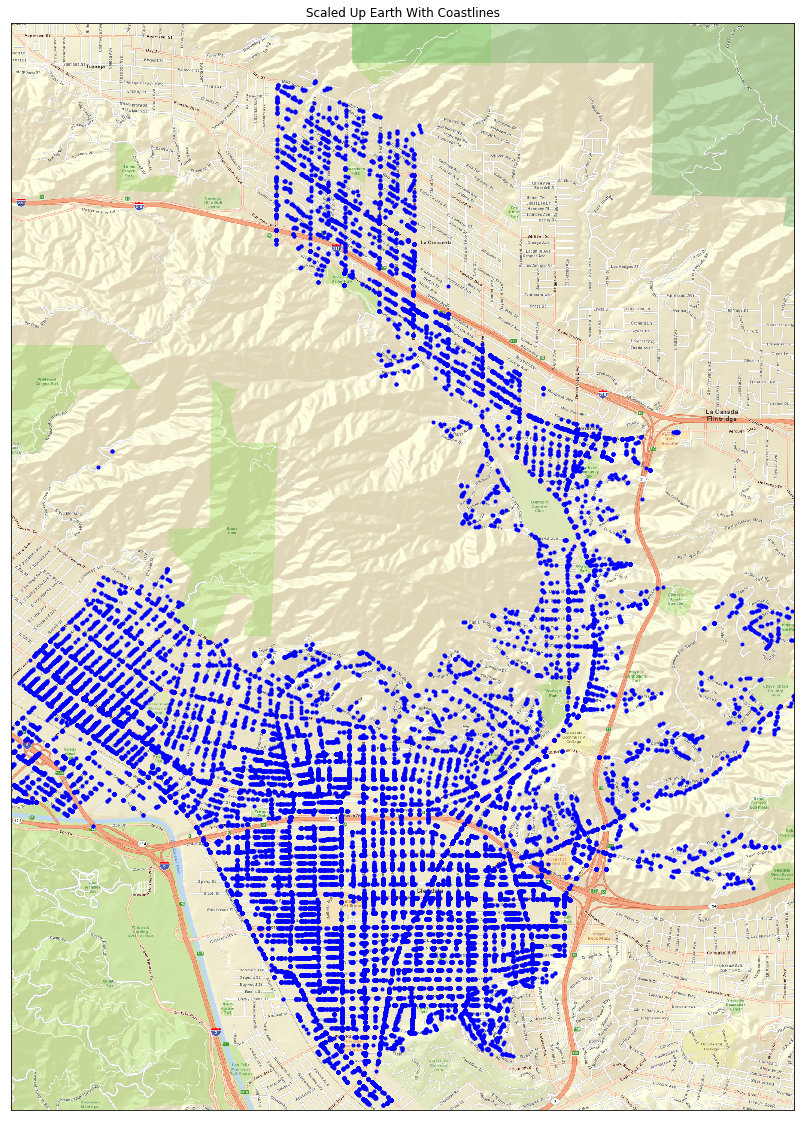

In [27]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(1,1,1)
ax.set_title("Scaled Up Earth With Coastlines")


map = Basemap(projection='cyl',
              resolution = 'l',
              llcrnrlon = -118.299950, 
              llcrnrlat = 34.119281, 
              urcrnrlon = -118.200180, 
              urcrnrlat = 34.257681, 
              lat_0=34.1425,
              lon_0=118.2551)


# We use a satelite image of Glendale as background.
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1800, verbose= True)
latitude = Glendale_City_Crime_data['latitude_x'].tolist()
longitude = Glendale_City_Crime_data['longitude_x'].tolist()

x,y = map(longitude, latitude)

map.plot(x, y, 'bo', markersize=3) 

plt.show()

In [28]:
Glendale_City_Crime_data.drop(['crime_class'], axis = 1, inplace= True)

Glendale_City_Crime_data = Glendale_City_Crime_data[(Glendale_City_Crime_data.Year >= 2014) &(Glendale_City_Crime_data.Year <= 2017)]
Glendale_City_Crime_data.drop(['Year'], axis = 1, inplace= True)

feature_cols = Glendale_City_Crime_data.columns.difference(['Main Category'])
dummy_categories = pd.get_dummies(Glendale_City_Crime_data["Main Category"], prefix='CAT')
Glendale_City_Crime_data = Glendale_City_Crime_data.join(dummy_categories)
Glendale_City_Crime_data.drop(['Main Category'], axis = 1, inplace= True)
target_cols = Glendale_City_Crime_data.columns.difference(feature_cols)

## 4. Training and Evaluating Models

In [29]:
from sklearn.model_selection  import train_test_split
from sklearn import metrics


X_all = Glendale_City_Crime_data[feature_cols]
y_all = Glendale_City_Crime_data[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,test_size=0.20)
print "Done split!"

print "Number of Training set: {}".format(len(X_train)) 
print "Number of Testing set: {}".format(len(X_test)) 

Done split!
Number of Training set: 47827
Number of Testing set: 11957


In [30]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Training time (secs): {:.3f}".format(end - start)

In [31]:
# Predict on training set and compute F1 score
from sklearn.metrics import accuracy_score
from sklearn.metrics import  log_loss

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    score = clf.score(features, target)
    end = time.time()
    print "Scoring time (secs): {:.3f}".format(end - start)
    return score

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

randomstate = 4321
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=20, random_state = randomstate),
    RandomForestClassifier(max_depth=50, n_estimators=100, random_state = randomstate),
    MLPClassifier(alpha=1, random_state = randomstate),
    OneVsRestClassifier(GradientBoostingClassifier(random_state = randomstate)),
    OneVsRestClassifier(AdaBoostClassifier(random_state = randomstate))
]

In [33]:
for clf in classifiers:    
    train_classifier(clf, X_train, y_train)  # note: using entire training set here   
    train_score = predict_labels(clf, X_test, y_test)
    print "Accuracy for testing set: {0:.0f}%\n".format(train_score*100)

Training KNeighborsClassifier...
Training time (secs): 0.091
Predicting labels using KNeighborsClassifier...
Scoring time (secs): 0.767
Accuracy for testing set: 20%

Training DecisionTreeClassifier...
Training time (secs): 0.531
Predicting labels using DecisionTreeClassifier...
Scoring time (secs): 0.013
Accuracy for testing set: 31%

Training RandomForestClassifier...
Training time (secs): 12.315
Predicting labels using RandomForestClassifier...
Scoring time (secs): 1.031
Accuracy for testing set: 18%

Training MLPClassifier...
Training time (secs): 1.897
Predicting labels using MLPClassifier...
Scoring time (secs): 0.017
Accuracy for testing set: 0%

Training OneVsRestClassifier...
Training time (secs): 19.659
Predicting labels using OneVsRestClassifier...
Scoring time (secs): 0.086
Accuracy for testing set: 7%

Training OneVsRestClassifier...
Training time (secs): 7.690
Predicting labels using OneVsRestClassifier...
Scoring time (secs): 0.310
Accuracy for testing set: 7%



## 5. Optimizing the Best Model

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


def fit_model(X, y):
    
    # Create a decision tree regressor object
    classifier = DecisionTreeClassifier(random_state=1234)

    # Set up the parameters we wish to tune
    parameters = {'max_depth':(40,60,80,100),
                  'min_samples_split' : (2,3,4),
                  'min_samples_leaf' : (1,2,3)}

    # Make an appropriate scoring function
    # functions ending with _error or _loss return a value to minimize, the lower the better
    scoring_function = metrics.make_scorer(metrics.accuracy_score)

    # Make the GridSearchCV object
    clf = GridSearchCV(classifier, param_grid = parameters, cv = 6, scoring = scoring_function)

    # Fit the learner to the data to obtain the optimal model with tuned parameters
    clf.fit(X, y)

    # Return the optimal model
    return clf

# Test fit_model on entire dataset
try:
    clf = fit_model(X_train, y_train)
    print "Successfully fit a model!"
except:
    print "Something went wrong with fitting a model."


Successfully fit a model!


In [35]:
train_score = predict_labels(clf, X_test, y_test)
print "Accuracy for testing set: {0:.0f}%\n".format(train_score*100)

Predicting labels using GridSearchCV...
Scoring time (secs): 0.014
Accuracy for testing set: 35%

